<img src="img/TOC.png" alt="Title Image" style="width:600px">

# Nanocomposites

There have been many PRISM-based theoretical studies focused on understanding how the design of the filler and matrix material in polymer nanocomposites (PNCs) lead to controlled morphologies and particle/filler dispersion in the matrix; much of this work is summarized in several recent reviews.[1-3] Traditional simulation methodologies are challenged to equilibrate large PNC systems with long matrix chains because the relaxation times of these systems are often much longer than comparable simulations at lower densities and/or short matrix chains. Results from PRISM calculations are, by definition, equilibrium predictions so that relaxation times and equilibration are not a problem. Furthermore, the problem of finite-size effects is not present in PRISM theory.

### Concepts Used
- Multicomponent PRISM
- Phase space "hopping"
- Heterogeneous interactions
- Domain interpolation
- Complex Molecular Structure
- Simulation derived $\hat{\omega}(k)$

### Tools Used
- pyPRISM.calculate.pair_correlation
- pyPRISM.calculate.pmf

### References
1.	Ganesan, V. and A. Jayaraman, Theory and simulation studies of effective interactions, phase behavior and morphology in polymer nanocomposites. Soft Matter, 2014. 10(1): p. 13-38.

2.	Jayaraman, A. and N. Nair, Integrating PRISM theory and Monte Carlo simulation to study polymer-functionalised particles and polymer nanocomposites. Molecular Simulation, 2012. 38(8-9): p. 751-761.

3.	Hall, L.M., A. Jayaraman, and K.S. Schweizer, Molecular theories of polymer nanocomposites. Current Opinion in Solid State and Materials Science, 2010. 14(2): p. 38-48.

4. Hooper, J.B.; Schweizer, K.S.; Contact Aggregation, Bridging, and Steric Stabilization in Dense Polymer Particle Mixtures, Macromolecules 2005, 38, 8858-8869

5. Modica, K.J.; Martin, T.B.; Jayaraman, A.J.; Effect of Architecture on the Structure
   and Interactions of Polymer Grafted Particles: Theory and Simulation, Macromolecules, 
   2017, 50 (12), pp 4854-4866
   
   

# Notebook Setup
To begin, please run `Kernel-> Restart & Clear Output` from the menu at the top of the notebook. It is a good idea to run this before starting any notebook so that the notebook is fresh for the user. Next, run the cell below (via the top menu-bar or `<Shift-Enter>`. If the cell throws an import error, there is likely something wrong with your environment.

If successful, you should see a set of logos appear below the cell. Which logos appear depend on what is inside the `hv.extension()` command at the bottom of the cell. If no logos appear and the cell throws an error, there is likely something wrong with your environment. 

### Troubleshooting:
- Did you activate the correct conda environment before starting the jupyter notebook? 
- If not using anaconda, did you install all dependencies before starting the jupyter notebook? 
- Is pyPRISM installed in your current environment on your `PYTHONPATH`? 

Holoviews + Bokeh Logos: ![Logos](img/import_check_bokeh.png)


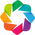

In [1]:
import pyPRISM
import numpy as np
import holoviews as hv
hv.extension('bokeh')


def interpolate_guess(domain_from,domain_to,rank,guess):
    '''Helper for upscaling the intial guesses'''
    guess = guess.reshape((domain_from.length,rank,rank))
    new_guess = np.zeros((domain_to.length,rank,rank))
    for i in range(rank):
        for j in range(rank):
            new_guess[:,i,j] = np.interp(domain_to.r,domain_from.r,guess[:,i,j])
    return new_guess.reshape((-1,))

# Bare Particle Nanocomposite

<img src="img/bare_composite.png" alt="Bare Composite" style="width:500px">

In this example, we use `pyPRISM` to study a polymer nanocomposite system in which polymer chains of length N = 100 are mixed with a bare nanoparticle.[4] The nanoparticle is of diameter D = 16d, where d is the diameter of one segment of the polymer chain (either a monomer or a coarse-grained bead). We plot the particle-particle pair correlations as a function of the range of the particle-polymer attraction. 


As usual, we'll define the plot aesthetics first.

In [2]:
%opts Curve Scatter [width=500,height=400] Layout [shared_axes=False] Scatter (size=10,alpha=0.5)
%opts Curve Scatter [fontsize={'xlabel':14,'xlabel':14,'ylabel':14,'ticks':12}]
%opts Overlay [legend_position='bottom_left']
%opts Layout [shared_axes=False]


colors = {}
colors[1.0] = 'blue'
colors[0.5] = 'red'
colors[0.25] = 'green'

ls = {}
ls[1.0] = 'solid'
ls[0.5] = 'dashed'
ls[0.25] = 'dotted'

markers = {}
markers[1.0] = 'o'
markers[0.5] = '^'
markers[0.25] = 'd'

First we load the reference data from Ref. 4

In [3]:
gr_compare = []
for density in [1.0,0.5,0.25]:
    fname = './data/BareComposite-Gr-alpha{}.csv'.format(density)
    x,y = np.loadtxt(fname,delimiter=',').T
    gr_compare.append([density,x,y])

Next we need to solve the PRISM equations, but we can't solve for the particle size we want (D=16d) directly. You can try it, but `pyPRISM` won't be able to converge the equations. Instead, we sequentially solve the PRISM equations starting for a small diameter particle and progressively increase the particle size. Each successive loop (or particle diameter) uses the solution from the last loop as a starting guess, greatly increasing the ability of `pyPRISM` to converge. This process is the so-called "phase space hopping".

In [4]:
d = 1.0 #polymer segment diameter
phi = 0.001 #volume fraction of nanoparticles
eta = 0.4 #total occupied volume fraction

sys = pyPRISM.System(['particle','polymer'],kT=1.0)
sys.domain = pyPRISM.Domain(dr=0.1,length=1024)

guess = np.zeros(sys.rank*sys.rank*sys.domain.length)
for D in np.arange(1.0,16.5,0.5):
    print('==> Solving for nanoparticle diameter D=',D)
    
    vd = 4.0/3.0 * np.pi * (d/2.0)**(3)
    vD = 4.0/3.0 * np.pi * (D/2.0)**(3)
    sys.diameter['polymer'] = d
    sys.diameter['particle'] = D
    sys.density['polymer'] = (1-phi)*eta/vd
    sys.density['particle'] = phi*eta/vD
    print('--> rho=',sys.density['polymer'],sys.density['particle'])

    sys.omega['polymer','polymer'] = pyPRISM.omega.FreelyJointedChain(length=100,l=4.0*d/3.0)
    sys.omega['polymer','particle'] = pyPRISM.omega.InterMolecular()
    sys.omega['particle','particle'] = pyPRISM.omega.SingleSite()
    
    
    sys.potential['polymer','polymer'] = pyPRISM.potential.HardSphere(sigma=d)
    sys.potential['polymer','particle'] = pyPRISM.potential.Exponential(sigma=(D+d)/2.0,alpha=0.5,epsilon=1.0)
    sys.potential['particle','particle'] = pyPRISM.potential.HardSphere(sigma=D)
    
    sys.closure['polymer','polymer'] = pyPRISM.closure.PercusYevick()
    sys.closure['polymer','particle'] = pyPRISM.closure.PercusYevick()
    sys.closure['particle','particle'] = pyPRISM.closure.HyperNettedChain()

    PRISM = sys.createPRISM()

    result = PRISM.solve(guess)

    guess = np.copy(PRISM.x)
    
    print('')

last_guess=guess


==> Solving for nanoparticle diameter D= 1.0
--> rho= 0.7631797831142566 0.000763943726841
0:  |F(x)| = 3.35879; step 1; tol 0.476156
1:  |F(x)| = 0.752641; step 1; tol 0.204052
2:  |F(x)| = 0.189662; step 1; tol 0.0571517
3:  |F(x)| = 0.0163282; step 1; tol 0.00667045
4:  |F(x)| = 8.51675e-05; step 1; tol 2.44859e-05
5:  |F(x)| = 5.70769e-07; step 1; tol 4.04217e-05

==> Solving for nanoparticle diameter D= 1.5
--> rho= 0.7631797831142566 0.000226353696842
0:  |F(x)| = 2.51597; step 1; tol 0.291082
1:  |F(x)| = 0.0149118; step 1; tol 3.1615e-05
2:  |F(x)| = 1.30481e-06; step 1; tol 6.89089e-09

==> Solving for nanoparticle diameter D= 2.0
--> rho= 0.7631797831142566 9.54929658551e-05
0:  |F(x)| = 4.36967; step 1; tol 0.268366
1:  |F(x)| = 0.0170008; step 1; tol 1.36234e-05
2:  |F(x)| = 3.64061e-06; step 1; tol 4.12714e-08

==> Solving for nanoparticle diameter D= 2.5
--> rho= 0.7631797831142566 4.88923985178e-05
0:  |F(x)| = 13.3593; step 0.449922; tol 0.456306
1:  |F(x)| = 4.12463; s

4:  |F(x)| = 0.0079935; step 1; tol 1.65727e-05
5:  |F(x)| = 1.46836e-05; step 1; tol 3.03692e-06

==> Solving for nanoparticle diameter D= 13.0
--> rho= 0.7631797831142566 3.47721313992e-07
0:  |F(x)| = 1411.41; step 1; tol 0.0319697
1:  |F(x)| = 1254.36; step 1; tol 0.710853
2:  |F(x)| = 655.034; step 1; tol 0.454781
3:  |F(x)| = 438.233; step 1; tol 0.402833
4:  |F(x)| = 91.4749; step 1; tol 0.146047
5:  |F(x)| = 18.8725; step 1; tol 0.0383089
6:  |F(x)| = 16.4094; step 1; tol 0.680402
7:  |F(x)| = 9.49042; step 1; tol 0.416652
8:  |F(x)| = 3.13953; step 1; tol 0.156239
9:  |F(x)| = 0.510996; step 1; tol 0.0238423
10:  |F(x)| = 0.372683; step 1; tol 0.478725
11:  |F(x)| = 0.0599878; step 1; tol 0.20626
12:  |F(x)| = 0.00299102; step 1; tol 0.00223747
13:  |F(x)| = 9.10151e-05; step 1; tol 0.000833355
14:  |F(x)| = 1.37508e-06; step 1; tol 0.000205434

==> Solving for nanoparticle diameter D= 13.5
--> rho= 0.7631797831142566 3.10498898274e-07
0:  |F(x)| = 783.486; step 1; tol 0.01737

/home/tbm/pyPRISM/pyPRISM/core/PRISM.py:230: UserWarning: Pair correlations are negative (value = -1.00e+00) for particle-particle pair!
  warnings.warn(warnstr.format(val,t1,t2))


3:  |F(x)| = 0.000607714; step 1; tol 2.78366e-07
4:  |F(x)| = 2.20878e-06; step 1; tol 1.18891e-05

==> Solving for nanoparticle diameter D= 15.0
--> rho= 0.7631797831142566 2.26353696842e-07
0:  |F(x)| = 5007.95; step 1; tol 0.132471
1:  |F(x)| = 546.895; step 1; tol 0.0107333
2:  |F(x)| = 355.407; step 0.481231; tol 0.380089
3:  |F(x)| = 137.061; step 1; tol 0.13385
4:  |F(x)| = 17.7858; step 1; tol 0.0151552
5:  |F(x)| = 0.708749; step 1; tol 0.00142916
6:  |F(x)| = 0.000705166; step 1; tol 8.90922e-07
7:  |F(x)| = 3.59783e-07; step 1; tol 2.34283e-07

==> Solving for nanoparticle diameter D= 15.5
--> rho= 0.7631797831142566 2.05147521558e-07
0:  |F(x)| = 1670.91; step 1; tol 0.0278465
1:  |F(x)| = 378.977; step 1; tol 0.0462983
2:  |F(x)| = 16.4635; step 1; tol 0.00169848
3:  |F(x)| = 1.77287; step 1; tol 0.0104365
4:  |F(x)| = 0.0164307; step 1; tol 7.73032e-05
5:  |F(x)| = 5.5953e-06; step 1; tol 1.04371e-07

==> Solving for nanoparticle diameter D= 16.0
--> rho= 0.7631797831142

Now that we have the D=16d solution as a guess, we can use it to solve the PRISM equations for three interaction widths. Note also that we have changed the domain characteristics (grid spacing and length of arrays), thus we need to use the interpolate_guess function (defined above) to convert the results using our prevous domain into the new domain. 

In [5]:
sys = pyPRISM.System(['particle','polymer'],kT=1.0)
sys.domain = pyPRISM.Domain(dr=0.075,length=2048)

vd = 4.0/3.0 * np.pi * (d/2.0)**(3)
vD = 4.0/3.0 * np.pi * (D/2.0)**(3)
sys.diameter['polymer'] = d
sys.diameter['particle'] = D
sys.density['polymer'] = (1-phi)*eta/vd
sys.density['particle'] = phi*eta/vD

sys.omega['polymer','polymer'] = pyPRISM.omega.FreelyJointedChain(length=100,l=4.0*d/3.0)
sys.omega['polymer','particle'] = pyPRISM.omega.NoIntra()
sys.omega['particle','particle'] = pyPRISM.omega.SingleSite()

sys.closure['polymer','polymer'] = pyPRISM.closure.PercusYevick()
sys.closure['polymer','particle'] = pyPRISM.closure.PercusYevick()
sys.closure['particle','particle'] = pyPRISM.closure.HyperNettedChain()
    
gr_results = []
guess = interpolate_guess(pyPRISM.Domain(dr=0.1,length=1024),sys.domain,sys.rank,last_guess)
for alpha in [0.25,0.5,1.0]:
    print('==> Solving for alpha=',alpha)
    sys.potential['polymer','polymer'] = pyPRISM.potential.HardSphere(sigma=d)
    sys.potential['polymer','particle'] = pyPRISM.potential.Exponential(sigma=(D+d)/2.0,alpha=alpha,epsilon=1.0)
    sys.potential['particle','particle'] = pyPRISM.potential.HardSphere(sigma=D)
    
    PRISM = sys.createPRISM()
    result = PRISM.solve(guess)
    
    x = sys.domain.r
    y = pyPRISM.calculate.pair_correlation(PRISM)['particle','particle']
    gr_results.append([alpha,x,y])


==> Solving for alpha= 0.25
0:  |F(x)| = 5662.39; step 1; tol 0.0366116
1:  |F(x)| = 506.876; step 1; tol 0.00721186
2:  |F(x)| = 484.693; step 0.0482191; tol 0.822948
3:  |F(x)| = 386.994; step 1; tol 0.60952
4:  |F(x)| = 181.28; step 1; tol 0.334363
5:  |F(x)| = 57.4303; step 1; tol 0.100619
6:  |F(x)| = 57.4266; step 6.28341e-05; tol 0.899883
7:  |F(x)| = 55.3488; step 1; tol 0.83605
8:  |F(x)| = 55.3217; step 1; tol 0.899118
9:  |F(x)| = 54.9051; step 0.0341534; tol 0.886497
10:  |F(x)| = 54.9045; step 1; tol 0.899981
11:  |F(x)| = 54.2824; step 0.0629851; tol 0.879722
12:  |F(x)| = 54.0923; step 0.00546448; tol 0.893705
13:  |F(x)| = 53.8822; step 0.00653873; tol 0.893024
14:  |F(x)| = 53.6781; step 0.0063891; tol 0.893192
15:  |F(x)| = 53.4702; step 0.00660002; tol 0.893042
16:  |F(x)| = 53.2445; step 0.00737255; tol 0.89242
17:  |F(x)| = 53.028; step 0.00714387; tol 0.892695
18:  |F(x)| = 52.7721; step 0.00869284; tol 0.891335
19:  |F(x)| = 52.4261; step 0.0123779; tol 0.888237


76:  |F(x)| = 6.66849; step 0.148919; tol 0.834358
77:  |F(x)| = 6.49641; step 0.0936889; tol 0.854148
78:  |F(x)| = 6.27982; step 0.173879; tol 0.840989
79:  |F(x)| = 6.21005; step 0.104383; tol 0.880113
80:  |F(x)| = 5.95206; step 0.311442; tol 0.826774
81:  |F(x)| = 5.84771; step 0.0658969; tol 0.86872
82:  |F(x)| = 5.52592; step 0.386533; tol 0.803673
83:  |F(x)| = 5.4901; step 0.0306027; tol 0.888372
84:  |F(x)| = 5.32078; step 0.0924585; tol 0.84534
85:  |F(x)| = 5.11388; step 1; tol 0.831368
86:  |F(x)| = 4.91527; step 0.233652; tol 0.831451
87:  |F(x)| = 3.94431; step 1; tol 0.62218
88:  |F(x)| = 2.71733; step 1; tol 0.427155
89:  |F(x)| = 1.00216; step 1; tol 0.164215
90:  |F(x)| = 0.163451; step 1; tol 0.0239411
91:  |F(x)| = 0.00369448; step 1; tol 0.000459807
92:  |F(x)| = 1.58342e-05; step 1; tol 1.65322e-05
==> Solving for alpha= 1.0
0:  |F(x)| = 8084.63; step 1; tol 0.342037
1:  |F(x)| = 2811.99; step 1; tol 0.10888
2:  |F(x)| = 2679.33; step 0.0540234; tol 0.817087
3:  

Here we reproduce Figure 1 from Reference 1.

In [6]:
%%opts Overlay [legend_position='top_right']

extents = (16,0.0,24,4.0)

gr_plots = []
for alpha,x,y in gr_results:
    label = 'alpha={} (pyPRISM)'.format(alpha)
    style = {'line_dash':ls[alpha],'color':colors[alpha]}
    c1 = hv.Curve((x,y),label=label,extents=extents)(style=style)
    gr_plots.append(c1)
    
for alpha,x,y in gr_compare:
    label = 'alpha={} (Ref 1)'.format(alpha)
    style = {'marker':markers[alpha],'color':colors[alpha]}
    c1 = hv.Scatter((x,y),label=label,extents=extents)(style=style)
    gr_plots.append(c1)
    
    
hv.Overlay(gr_plots).redim.label(x='r',y='g(r)')

:Overlay
   .Curve.Alpha_equals_0_full_stop_25_left_parenthesis_pyPRISM_right_parenthesis :Curve   [x]   (y)
   .Curve.Alpha_equals_0_full_stop_5_left_parenthesis_pyPRISM_right_parenthesis  :Curve   [x]   (y)
   .Curve.Alpha_equals_1_full_stop_0_left_parenthesis_pyPRISM_right_parenthesis  :Curve   [x]   (y)
   .Scatter.Alpha_equals_1_full_stop_0_left_parenthesis_Ref_1_right_parenthesis  :Scatter   [x]   (y)
   .Scatter.Alpha_equals_0_full_stop_5_left_parenthesis_Ref_1_right_parenthesis  :Scatter   [x]   (y)
   .Scatter.Alpha_equals_0_full_stop_25_left_parenthesis_Ref_1_right_parenthesis :Scatter   [x]   (y)

# Polymer Grafted Particle  Nanocomposite
<img src="img/grafted_composite.png" alt="Grafted Composite" style="width:600px">

In this example, we use `pyPRISM` to study a polymer nanocomposite system in which polymer chains of varying length $N_{matrix} = 10, 60$ are mixed with a nanoparticle permanently grafted with polymer chains. The grafted chains are of length $N_{graft}=20$ and are of either linear or comb polymer architecture with side chain length $N_{sc} = 3$. All interactions in this system are modeled as athermal (hard-sphere). We plot the particle-particle potential of mean force as a function of the length of the matrix chains and the grafted chain architecture. The details of this system are described in Ref. 5.


As always, we define the aesthetics first

In [7]:
%opts Curve Scatter [width=500,height=400] Layout [shared_axes=False] Scatter (size=10,alpha=0.5)
%opts Curve Scatter [fontsize={'xlabel':14,'xlabel':14,'ylabel':14,'ticks':12}]
%opts Overlay [legend_position='bottom_left']
%opts Layout [shared_axes=False]


colors = {}
colors['linear',10] = 'blue'
colors['linear',60] = 'red'
colors['comb',10] = 'green'
colors['comb',60] = 'magenta'

ls = {}
ls['linear',10] = 'solid'
ls['linear',60] = 'dashed'
ls['comb',10] = 'dotted'
ls['comb',60] = 'dashdot'


markers = {}
markers['linear',10] = 'o'
markers['linear',60] = '^'
markers['comb',10] = 'd'
markers['comb',60] = 's'


Next we load the data from the literature

In [8]:
PMF_compare = []
for arch in ['linear','comb']:
    for Nmatrix in [10,60]:
        fname = './data/GraftedComposite-Gr-{}-Nmatrix{}-PP.dat'.format(arch,Nmatrix)
        x,y = np.loadtxt(fname).T
        y = -np.log(y)
        PMF_compare.append([arch,Nmatrix,x,y])

/home/tbm/software/anaconda3/4.4.0/envs/pyPRISM_py3_dev/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


Finally, we conduct the calculation. Unlike the bare-composite case, we can directly solve for the results but we still use loops to quickly scan a small parameter space and gather the results.

Note that this calculation is considerably more complicated than the previous if only for the fact that we have three components for the first time. This results in a significantly longer script for the calculation. 

In [9]:
import pyPRISM
from pyPRISM.calculate.pair_correlation import pair_correlation
from pyPRISM.calculate.pmf import pmf
import numpy as np

D = 5.0 #grafted nanoparticle diameter
d = 1.0 #polymer segement diameter
phi = 0.001 #grafted particle volume fraction
eta = 0.35 #total occupied volume fraction
vd = 4.0/3.0 * np.pi * (d/2.0)**(3) #volume of one polymer segement
vD = 4.0/3.0 * np.pi * (D/2.0)**(3) #volume of one nanoparticle

sys = pyPRISM.System(['particle','graft','matrix'],kT=1.0)
sys.domain = pyPRISM.Domain(dr=0.1,length=1024)

sys.diameter['particle'] = D
sys.diameter['graft']    = d
sys.diameter['matrix']   = d

sys.omega['particle','matrix']  = pyPRISM.omega.InterMolecular()
sys.omega['graft','matrix']     = pyPRISM.omega.InterMolecular()
sys.omega['particle','particle'] = pyPRISM.omega.SingleSite()

sys.closure[sys.types,sys.types]   = pyPRISM.closure.PercusYevick()
sys.closure['particle','particle'] = pyPRISM.closure.HyperNettedChain()

sys.potential[sys.types,sys.types]   = pyPRISM.potential.HardSphere(sigma=d)
sys.potential['particle',sys.types]  = pyPRISM.potential.HardSphere(sigma=(d + D)/2.0)
sys.potential['particle','particle'] = pyPRISM.potential.HardSphere(sigma=D)

guess = np.zeros((sys.domain.length,sys.rank,sys.rank))
PMF_results = []
for Nmatrix in [60,10]:
    sys.omega['matrix','matrix']   = pyPRISM.omega.FromFile('./data/GraftedComposite-Omega-matrix-N{}.dat'.format(Nmatrix))
    sys.omega['graft','graft']     = pyPRISM.omega.FromFile('./data/GraftedComposite-Omega-linear-GG.dat')
    sys.omega['graft','particle']  = pyPRISM.omega.FromFile('./data/GraftedComposite-Omega-linear-GP.dat')
    
    numGraftBeads = 500
    vPGP = vD + numGraftBeads*vd
    sys.density['matrix']   = (1-phi)*eta/vd
    sys.density['particle'] = phi*eta/vPGP
    sys.density['graft']    = numGraftBeads * phi*eta/vPGP
    print('--> rho=',sys.density['graft'],sys.density['particle'],sys.density['matrix'])
    PRISM = sys.createPRISM()
    PRISM.solve(guess)
    guess = np.copy(PRISM.x)
    PMF_results.append(['linear',Nmatrix,sys.domain.r,pmf(PRISM)['particle','particle']])
    
    numGraftBeads = 1250
    vPGP = vD + numGraftBeads*vd
    sys.density['matrix']  = (1-phi)*eta/vd
    sys.density['particle'] = phi*eta/vPGP
    sys.density['graft']    = numGraftBeads * phi*eta/vPGP
    print('--> rho=',sys.density['graft'],sys.density['particle'],sys.density['matrix'])
    sys.omega['matrix','matrix']   = pyPRISM.omega.FromFile('./data/GraftedComposite-Omega-matrix-N{}.dat'.format(Nmatrix))
    sys.omega['graft','graft']     = pyPRISM.omega.FromFile('./data/GraftedComposite-Omega-comb-GG.dat')
    sys.omega['graft','particle']  = pyPRISM.omega.FromFile('./data/GraftedComposite-Omega-comb-GP.dat')
    PRISM = sys.createPRISM()
    result = PRISM.solve(guess)
    PMF_results.append(['comb',Nmatrix,sys.domain.r,pmf(PRISM)['particle','particle']])

--> rho= 0.0005347606087887683 1.0695212175775368e-06 0.6677823102249745
0:  |F(x)| = 125.67; step 0.0222735; tol 0.853672
1:  |F(x)| = 110.033; step 1; tol 0.689955
2:  |F(x)| = 98.7161; step 0.360292; tol 0.724395
3:  |F(x)| = 96.916; step 0.0346837; tol 0.867475
4:  |F(x)| = 77.7223; step 1; tol 0.677262
5:  |F(x)| = 52.3436; step 1; tol 0.412816
6:  |F(x)| = 52.2497; step 0.00201374; tol 0.896772
7:  |F(x)| = 45.2768; step 1; tol 0.723781
8:  |F(x)| = 42.7455; step 0.0847881; tol 0.80218
9:  |F(x)| = 37.6435; step 0.200722; tol 0.697978
10:  |F(x)| = 32.0038; step 1; tol 0.650526
11:  |F(x)| = 25.3211; step 0.309525; tol 0.563386
12:  |F(x)| = 21.2678; step 0.353001; tol 0.634926
13:  |F(x)| = 17.046; step 0.420115; tol 0.578152
14:  |F(x)| = 10.0361; step 1; tol 0.311978
15:  |F(x)| = 9.52045; step 0.0566309; tol 0.809896
16:  |F(x)| = 6.99251; step 1; tol 0.590338
17:  |F(x)| = 3.87908; step 1; tol 0.313649
18:  |F(x)| = 3.59957; step 0.091973; tol 0.774974
19:  |F(x)| = 3.16073;

Finally, plotting the results

In [10]:
%%opts Overlay [legend_position='top_right']
from math import sqrt

extents = (10,-0.2,40,0.2)
gr_plots = []
for arch,Nmatrix,x,y in PMF_results:
    key = (arch,Nmatrix)
    label = 'alpha={} (pyPRISM)'.format(key)
    style = {'line_dash':ls[key],'color':colors[key]}
    c1 = hv.Curve((x,y),label=label,extents=extents)(style=style)
    gr_plots.append(c1)
    
step = 10
for arch,Nmatrix,x,y in PMF_compare:
    x = x[::step]
    y = y[::step]
    key = (arch,Nmatrix)
    label = 'alpha={} (Ref 1)'.format(key)
    style = {'marker':markers[key],'color':colors[key]}
    c1 = hv.Scatter((x,y),label=label,extents=extents)(style=style)
    gr_plots.append(c1)
    
    
hv.Overlay(gr_plots).redim.label(x='r',y='W(r)')

:Overlay
   .Curve.Alpha_equals_left_parenthesis_apostrophe_linear_apostrophe_comma_60_right_parenthesis_left_parenthesis_pyPRISM_right_parenthesis :Curve   [x]   (y)
   .Curve.Alpha_equals_left_parenthesis_apostrophe_comb_apostrophe_comma_60_right_parenthesis_left_parenthesis_pyPRISM_right_parenthesis   :Curve   [x]   (y)
   .Curve.Alpha_equals_left_parenthesis_apostrophe_linear_apostrophe_comma_10_right_parenthesis_left_parenthesis_pyPRISM_right_parenthesis :Curve   [x]   (y)
   .Curve.Alpha_equals_left_parenthesis_apostrophe_comb_apostrophe_comma_10_right_parenthesis_left_parenthesis_pyPRISM_right_parenthesis   :Curve   [x]   (y)
   .Scatter.Alpha_equals_left_parenthesis_apostrophe_linear_apostrophe_comma_10_right_parenthesis_left_parenthesis_Ref_1_right_parenthesis :Scatter   [x]   (y)
   .Scatter.Alpha_equals_left_parenthesis_apostrophe_linear_apostrophe_comma_60_right_parenthesis_left_parenthesis_Ref_1_right_parenthesis :Scatter   [x]   (y)
   .Scatter.Alpha_equals_left_parenthesis_apostrophe_comb_apostrophe_comma_10_right_parenthesis_left_parenthesis_Ref_1_right_parenthesis   :Scatter   [x]   (y)
   .Scatter.Alpha_equals_left_parenthesis_apostrophe_comb_apostrophe_comma_60_right_parenthesis_left_parenthesis_Ref_1_right_parenthesis   :Scatter   [x]   (y)

# Summary
This notebook has covered two examples of nanocomposite systems which are significantly more complex than examples in previous notebooks. We also discuss the strategies we use to converge the PRISM equations for these systems, as we cannot directly solve for the answer. 

<img src="img/tracks.png" alt="Tutorial Tracks Image" style="width:600px" >

[NB0.Introduction](NB0.Introduction.ipynb) $\cdot$   [NB1.PythonBasics](NB1.PythonBasics.ipynb) $\cdot$   [NB2.Theory.General](NB2.Theory.General.ipynb) $\cdot$   [NB3.Theory.PRISM](NB3.Theory.PRISM.ipynb) $\cdot$   [NB4.pyPRISM.Overview](NB4.pyPRISM.Overview.ipynb) $\cdot$   [NB5.CaseStudies.PolymerMelts](NB5.CaseStudies.PolymerMelts.ipynb) $\cdot$   [NB6.CaseStudies.Nanocomposites](NB6.CaseStudies.Nanocomposites.ipynb) $\cdot$   [NB7.CaseStudies.Copolymers](NB7.CaseStudies.Copolymers.ipynb) $\cdot$   [NB8.pyPRISM.Internals](NB8.pyPRISM.Internals.ipynb) $\cdot$   [NB9.pyPRISM.Advanced](NB9.pyPRISM.Advanced.ipynb) 

# Legal

## Disclaimer
Any identification of commercial or open-source software in these notebooks is done so purely in order to specify the methodology adequately. Such identification is not intended to imply recommendation or endorsement by the National Institute of Standards and Technology, nor is it intended to imply that the softwares identified are necessarily the best available for the purpose. 

## License
This software was developed by employees of the National Institute of Standards and Technology (NIST), an agency of the Federal Government. Pursuant to title 17 United States Code Section 105, works of NIST employees are not subject to copyright protection in the United States and are considered to be in the public domain. Permission to freely use, copy, modify, and distribute this software and its documentation without fee is hereby granted, provided that this notice and disclaimer of warranty appears in all copies.

THE SOFTWARE IS PROVIDED 'AS IS' WITHOUT ANY WARRANTY OF ANY KIND, EITHER EXPRESSED, IMPLIED, OR STATUTORY, INCLUDING, BUT NOT LIMITED TO, ANY WARRANTY THAT THE SOFTWARE WILL CONFORM TO SPECIFICATIONS, ANY IMPLIED WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE, AND FREEDOM FROM INFRINGEMENT, AND ANY WARRANTY THAT THE DOCUMENTATION WILL CONFORM TO THE SOFTWARE, OR ANY WARRANTY THAT THE SOFTWARE WILL BE ERROR FREE. IN NO EVENT SHALL NIST BE LIABLE FOR ANY DAMAGES, INCLUDING, BUT NOT LIMITED TO, DIRECT, INDIRECT, SPECIAL OR CONSEQUENTIAL DAMAGES, ARISING OUT OF, RESULTING FROM, OR IN ANY WAY CONNECTED WITH THIS SOFTWARE, WHETHER OR NOT BASED UPON WARRANTY, CONTRACT, TORT, OR OTHERWISE, WHETHER OR NOT INJURY WAS SUSTAINED BY PERSONS OR PROPERTY OR OTHERWISE, AND WHETHER OR NOT LOSS WAS SUSTAINED FROM, OR AROSE OUT OF THE RESULTS OF, OR USE OF, THE SOFTWARE OR SERVICES PROVIDED HEREUNDER.

Distributions of NIST software should also include copyright and licensing statements of any third-party software that are legally bundled with the code in compliance with the conditions of those licenses.